# Format Parks
This notebooks formats and begins to look at data from National and State parks with the goal of organizing their information into a netcdf file.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd

data_dir = "/pool0/home/steinadi/data/drought/DatabaseDrafts"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Good to go
# ----------
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[0,1,2], usecols='B:Q')
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,20), header=1, sheet_name="Overnight", usecols='B:N', index_col=[0,1,2])

# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Overnight", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Total", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Day Use", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Day User Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Overnight Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)

# Needs splicing
# --------------
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Day Use", skiprows=np.arange(1,6), index_col=0, header=1) # some totals that I think can be cut out?
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Overnight", skiprows=np.arange(1,7), index_col=2, header=1) # also some strange totals

Load in files

In [3]:
nat_park_visits = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[1,2], usecols='B:Q')
# need to sort the index to better optimize things later
nat_park_visits = nat_park_visits.sort_index()
nat_park_overnight = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,20), header=1, sheet_name="Overnight", usecols='B:N', index_col=[1,2,3])
# need to sort the index to better optimize things later
nat_park_overnight = nat_park_overnight.sort_index()

<AxesSubplot:>

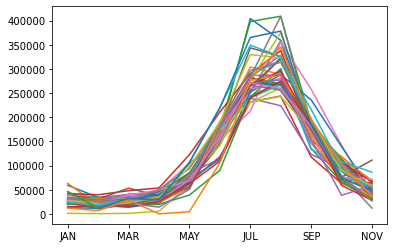

In [4]:
# do a plot just cause
nat_park_visits.loc["Mount Rainer National Park"][['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].transpose()[:-1].plot(legend=False)

In [5]:
# collect all given years and parks from both the daily and overnight
parks = []
years = []
for dex in nat_park_visits.index[:]:
    if dex[0] not in parks:
        parks.append(dex[0])
    if dex[1] not in years:
        years.append(int(dex[1]))
for dex in  nat_park_overnight.index:
    if dex[0] not in parks:
        parks.append(dex[0])
    if dex[1] not in years:
        years.append(dex[1])
print(parks)
# cut off the nan and All Years
years = years[:-2]
# sort years
years = sort(years)
print(years)

['Crater Lake', 'John Day Fossil Beds National Monument', 'Klondike Gold Rush National Recreation Area', 'Lake Chelan National Recreation Area', 'Lake Roosevelt National Recreation Area', 'Lewis and Clark National Historic Place', 'Mount Rainer National Park', 'North Cascades National Park', 'Olympic National Park', 'Oregon Caves National Park and National Monument', 'Ross Lake National Recreation Area', 'San Juan National Historic Park']
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [6]:
# also nab month names for manipulating the vists data
months=list(nat_park_visits.columns[1:-1])
print(months)

['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']


In [7]:
# Develop a new DataFrame so that we can have it as a timeseries
revised_nat_park_visits = pd.DataFrame(index=pd.date_range(start=f"{years[0]}", end=f'{years[-1]}', freq='MS'), columns=parks)
# collect where we throw errors
errors = []
for park in parks:
    for year in years:
        for month_num, month in enumerate(months):
            try:
                revised_nat_park_visits[park].loc[f'{year}-{month_num+1}-01'] = nat_park_visits.loc[park, year][month].values[0]
            except:
                errors.append((park, year, month))

# set types
for park in parks:
    revised_nat_park_visits[park] = revised_nat_park_visits[park].astype(float)

In [8]:
# did check, these errors are where there is no data, so we did things right above
# errors

In [9]:
# tada
revised_nat_park_visits

,Crater Lake,John Day Fossil Beds National Monument,Klondike Gold Rush National Recreation Area,Lake Chelan National Recreation Area,Lake Roosevelt National Recreation Area,Lewis and Clark National Historic Place,Mount Rainer National Park,North Cascades National Park,Olympic National Park,Oregon Caves National Park and National Monument,Ross Lake National Recreation Area,San Juan National Historic Park
1979-01-01,6771.0,295.0,0.0,NaN,2095.0,1498.0,24214.0,2556.0,48453.0,1158.0,NaN,6786.0
1979-02-01,5820.0,1886.0,0.0,NaN,2698.0,2809.0,15342.0,4350.0,38221.0,1142.0,NaN,4227.0
1979-03-01,10617.0,4978.0,0.0,NaN,13027.0,7088.0,40179.0,5465.0,75100.0,4617.0,NaN,6288.0
1979-04-01,11004.0,4829.0,0.0,NaN,30627.0,5547.0,43153.0,21066.0,105322.0,4815.0,NaN,5913.0
1979-05-01,21528.0,7883.0,0.0,NaN,73162.0,7406.0,65792.0,58174.0,130894.0,6806.0,NaN,6060.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,98266.0,24326.0,11467.0,5600.0,93586.0,21485.0,184166.0,8581.0,399907.0,5464.0,108316.0,13536.0
2019-10-01,41635.0,13350.0,6621.0,2926.0,78402.0,22874.0,74355.0,373.0,182944.0,10344.0,77083.0,27989.0
2019-11-01,16843.0,7980.0,6049.0,1299.0,49674.0,13438.0,48248.0,101.0,108204.0,3885.0,27716.0,12982.0
2019-12-01,8601.0,7659.0,3670.0,949.0,62692.0,8368.0,39161.0,81.0,72359.0,2228.0,12694.0,29850.0


In [10]:
nat_park_visits_ds = xr.Dataset(
    coords = dict(
        time = revised_nat_park_visits.index,
        park = parks,
    ),
    data_vars=dict(
        day_visits=(["time","park"], np.abs(revised_nat_park_visits.values))
    )
)
nat_park_visits_ds

<xarray.Dataset>
Dimensions:     (time: 493, park: 12)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-01-01
  * park        (park) <U48 'Crater Lake' ... 'San Juan National Historic Park'
Data variables:
    day_visits  (time, park) float64 6.771e+03 295.0 0.0 ... 8.037e+03 1.062e+04

Success!! Did double check that I didn't transpose it weird and we good. Going to save this first version.

In [11]:
#nat_park_visits_ds.to_netcdf('/pool0/home/steinadi/data/drought/drought_impact/Data/national_parks_v1.nc')

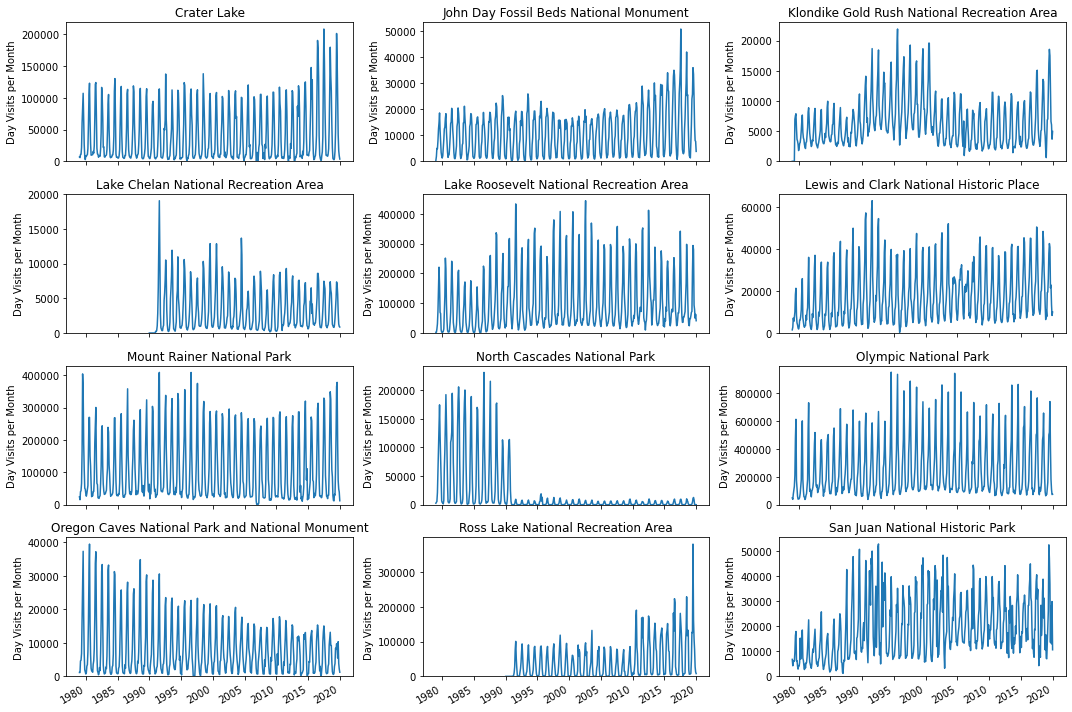

In [12]:
fig, axs = plt.subplots(4,3, figsize=(15,10), sharex=True)
ax_all = axs.ravel()

for ax, park in zip(ax_all, parks):
    nat_park_visits_ds['day_visits'].sel(park=park).plot(ax=ax)
    ax.set_title(park)
    ax.set_ylabel('Day Visits per Month')
    ax.set_xlabel('')
    ax.set_ylim(0,ax.get_ylim()[1])

plt.tight_layout()

There used to be a negative value in the San Juan National Historic Park, below was checking it out.

np.where(nat_park_visits_ds.isel(park=11)['day_visits'].values<0)

nat_park_visits_ds.isel(park=11)['day_visits'].values[286]

nat_park_visits_ds.isel(park=11)['time'].values[286]

Lmao, found a fun typo in the original data. Did double check with the spreadsheet, I did not introduce it. Made a comment in the original spreadsheet, so will go ahead and fix it

Hm, we should check if there are any other negative values

for park in parks:
    print(park, np.where(nat_park_visits_ds.sel(park=park)['day_visits'].values<0))

Cool cool, that was the only one.

## Now to add in the overnight data

In [13]:
nat_park_overnight

State  \
Park Name                       Year   Month                 
Crater Lake                     1979.0 1979 Totals      OR   
                                       April            OR   
                                       August           OR   
                                       December         OR   
                                       February         OR   
...                                                    ...   
San Juan National Historic Park 2020.0 May              WA   
                                       November         WA   
                                       October          WA   
                                       Report Totals    WA   
                                       September        WA   

                                                     Recreation Visitors  \
Park Name                       Year   Month                               
Crater Lake                     1979.0 1979 Totals              410749.0   
                                       April                     11004.0   
                                       August                   107031.0   
                                       December                   2599.0   
                                       February                   5820.0   
...                                                                  ...   
San Juan National Historic Park 2020.0 May                       22040.0   
                                       November                  31646.0   
                                       October                   43146.0   
                                       Report Totals           8361027.0   
                                       September                 55754.0   

                                                     Non-Recreation Visitors  \
Park Name                       Year   Month                                   
Crater Lake                     1979.0 1979 Totals                   35648.0   
                                       April                          1311.0   
                                       August                         5379.0   
                                       December                        464.0   
                                       February                        795.0   
...                                                                      ...   
San Juan National Historic Park 2020.0 May                            6287.0   
                                       November                       6084.0   
                                       October                        6287.0   
                                       Report Totals                296092.0   
                                       September                      6084.0   

                                                     Concession Lodging  \
Park Name                       Year   Month                              
Crater Lake                     1979.0 1979 Totals              18097.0   
                                       April                        0.0   
                                       August                    6362.0   
                                       December                     0.0   
                                       February                     0.0   
...                                                                 ...   
San Juan National Historic Park 2020.0 May                          0.0   
                                       November                     0.0   
                                       October                      0.0   
                                       Report Totals                0.0   
                                       September                    0.0   

                                                     Tent Campers RV Campers  \
Park Name                       Year   Month                                   
Crater Lake                     1979.0 1979 Totals         8320.0    34677.0   


Now this time we can't just make a new DataFrame because we have multiple variables and aren't just transposing like last time ... not to mention the individual totals in there. So instead we'll add it directly to the dataset

In [14]:
long_months = []
long_month_errors = []
for dex in nat_park_overnight.index:
    try:
        if dex[2] not in long_months and "Totals" not in dex[2] and "Visitors" not in dex[2]:
            long_months.append(dex[2])
    except:
        long_month_errors.append(dex)
print(long_months)
print()
print(long_month_errors)

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

[('Lake Chelan National Recreation Area', 2004.0, 2004.0), ('Lake Roosevelt National Recreation Area', 1990.0, 1990.0), ('Oregon Caves National Park and National Monument', 1979.0, nan), ('Oregon Caves National Park and National Monument', 1982.0, 1982.0), ('Oregon Caves National Park and National Monument', 1983.0, 1983.0), ('Oregon Caves National Park and National Monument', 1986.0, 1986.0), ('Oregon Caves National Park and National Monument', 1987.0, 1987.0), ('Oregon Caves National Park and National Monument', 2003.0, 2003.0), ('Ross Lake National Recreation Area', 1990.0, nan)]


Hmmm ... I think this is fine, will come back if issue

In [15]:
# to make life easier, since these are just the months
# spelled out I'm going to put them in an order that I
# can zip through their numbers later like we did before
long_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [16]:
# just popping off the state value cause don't really need that
overnight_data = list(nat_park_overnight.columns)[1:]
overnight_data

['Recreation Visitors',
 'Non-Recreation Visitors',
 'Concession Lodging',
 'Tent Campers',
 'RV Campers',
 'Concession Camping',
 'Backcountry Campers',
 'Misc Campers',
 'Total Overnight Stays']

In [17]:
# check we get values
nat_park_overnight.loc[parks[0],years[0],long_months[0]]

<ipython-input-17-313a7e70d834>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  nat_park_overnight.loc[parks[0],years[0],long_months[0]]


,,,State,Recreation Visitors,Non-Recreation Visitors,Concession Lodging,Tent Campers,RV Campers,Concession Camping,Backcountry Campers,Misc Campers,Total Overnight Stays
Park Name,Year,Month,,,,,,,,,,
Crater Lake,1979.0,January,OR,6771.0,650.0,0.0,0.0,0.0,0.0,68.0,0.0,68.0


In [61]:
nat_park_ds = nat_park_visits_ds.copy()
nat_park_ds = nat_park_ds.rename({'day_visits':'Day Visits'})

for o_data in overnight_data:
    # setup the shape
    nat_park_ds[o_data] = np.nan*nat_park_ds['Day Visits'].copy()
    # go through and input data
    for park in parks:
        for year in years:
            for month, month_num in zip(long_months, np.arange(1,13,1)):
                try:
                    nat_park_ds[o_data].loc[f"{int(year)}-{month_num}-01"] = 1 #nat_park_overnight.loc[park, year, month][o_data].values
                except:
                    pass
nat_park_ds

<xarray.Dataset>
Dimensions:                  (time: 493, park: 12)
Coordinates:
  * time                     (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * park                     (park) <U48 'Crater Lake' ... 'San Juan National...
Data variables:
    Day Visits               (time, park) float64 6.771e+03 295.0 ... 1.062e+04
    Recreation Visitors      (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Non-Recreation Visitors  (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Concession Lodging       (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Tent Campers             (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    RV Campers               (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Concession Camping       (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Backcountry Campers      (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Misc Campers             (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Total Overnight Stays    (time, park) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0

In [20]:
nat_park_ds.attrs = {
    "Source": "https://irma.nps.gov/STATS/Reports/Park",
    "Original Download": "3/9/21 by K. Hegewisch",
    "Reformatted": "11/12/21 by A. Stein",
    "Notes": "May contain typos from original copying"
}
nat_park_ds

<xarray.Dataset>
Dimensions:                  (time: 493, park: 12)
Coordinates:
  * time                     (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * park                     (park) <U48 'Crater Lake' ... 'San Juan National...
Data variables:
    Day Visits               (time, park) float64 6.771e+03 295.0 ... 1.062e+04
    Recreation Visitors      (time, park) float64 1.158e+03 ... 1.062e+04
    Non-Recreation Visitors  (time, park) float64 30.0 30.0 ... 6.287e+03
    Concession Lodging       (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Tent Campers             (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RV Campers               (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Concession Camping       (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Backcountry Campers      (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Misc Campers             (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Total Overnight Stays    (time, park) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Source:             https://irma.nps.gov/STATS/Reports/Park
    Original Download:  3/9/21 by K. Hegewisch
    Reformatted:        11/12/21 by A. Stein
    Notes:              May contain typos from original copying

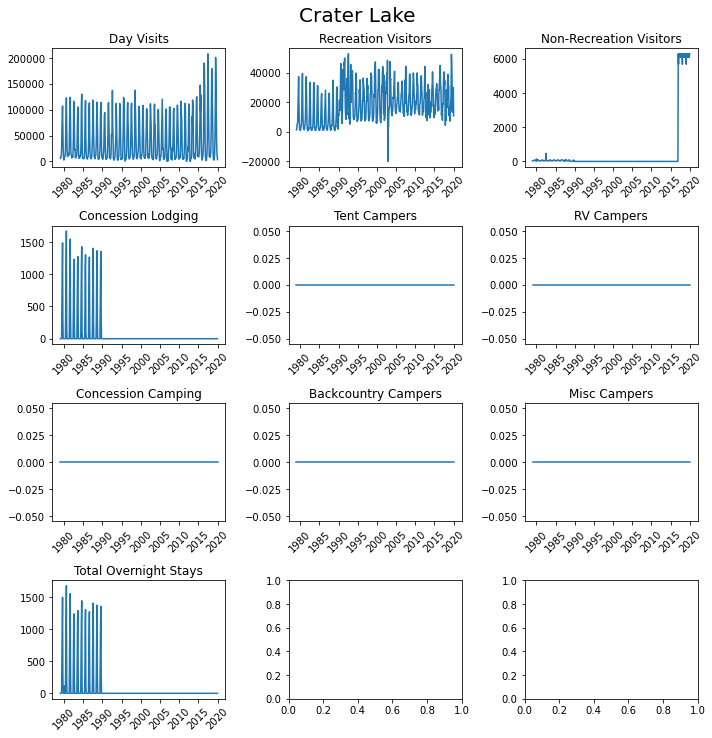

In [55]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
ax = axs.ravel()

park = parks[0]

for i, var in enumerate(nat_park_ds.var()):
    ax[i].plot(nat_park_ds['time'].values, nat_park_ds[var].sel(park=park).values)
    ax[i].set_title(var)
    ax[i].tick_params(axis='x', rotation=45)

fig.text(0.42, 1, park, fontsize=20)
plt.tight_layout()

In [54]:
# hm, that's not quite right.

nat_park_overnight.loc['Crater Lake',1979,'August']

<ipython-input-54-cd6ce6752c62>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  nat_park_overnight.loc['Crater Lake',1979,'August']


,,,State,Recreation Visitors,Non-Recreation Visitors,Concession Lodging,Tent Campers,RV Campers,Concession Camping,Backcountry Campers,Misc Campers,Total Overnight Stays
Park Name,Year,Month,,,,,,,,,,
Crater Lake,1979.0,August,OR,107031.0,5379.0,6362.0,2092.0,11858.0,0.0,768.0,0.0,21080.0


In [56]:
nat_park_ds.sel(park='Crater Lake', time='1979-08-01')

<xarray.Dataset>
Dimensions:                  ()
Coordinates:
    time                     datetime64[ns] 1979-08-01
    park                     <U48 'Crater Lake'
Data variables:
    Day Visits               float64 1.07e+05
    Recreation Visitors      float64 3.732e+04
    Non-Recreation Visitors  float64 90.0
    Concession Lodging       float64 1.486e+03
    Tent Campers             float64 0.0
    RV Campers               float64 0.0
    Concession Camping       float64 0.0
    Backcountry Campers      float64 0.0
    Misc Campers             float64 0.0
    Total Overnight Stays    float64 1.493e+03
Attributes:
    Source:             https://irma.nps.gov/STATS/Reports/Park
    Original Download:  3/9/21 by K. Hegewisch
    Reformatted:        11/12/21 by A. Stein
    Notes:              May contain typos from original copying

So for some reason the value is getting written in as a `0` rather than its actual value?

Oh, I'm betting this is a lexsort opitmization error thing, frick.